# Al Grade Model — Co Grade (Feed → Product)

Predict **Product Co Grade** from **Feed Co Grade** using the **Al Grade Model.xlsx** (sheet **Model Data**).

**Notebook outline:**
1. **Config and load data** — Path to Excel, read sheet.
2. **Select columns** — Detect Feed Co Grade (feature) and Product Co Grade (target).
3. **EDA** — Shape, head, info, describe, nulls, box plots (outlier counts), correlation, OLS.
4. **Build X and y** — Drop missing, optional runtime filter.
5. **Train/test and linear model** — 80/20 split, fit, R², MAE, actual vs predicted.
6. **Outlier handling** — Winsorize or remove outliers; report **how many outliers were removed**, plus Adj R², t-value, and 95% CI.
7. **Ridge and other models** — Tune Ridge; compare RF, XGBoost, GB, Extra Trees.

## 1. Config and load data

In [1]:
import pandas as pd
import os

# Path to Al Grade Model.xlsx (try project root and data/)
ROOT = os.path.abspath(os.path.join(os.getcwd(), '..')) if os.path.basename(os.getcwd()) == 'notebooks' else os.getcwd()
PATH_XLSX = os.path.join(ROOT, 'Al Grade Model.xlsx')
if not os.path.exists(PATH_XLSX):
    PATH_XLSX = os.path.join(ROOT, 'data', 'Al Grade Model.xlsx')
if not os.path.exists(PATH_XLSX):
    raise FileNotFoundError('Al Grade Model.xlsx not found in project root or data/. Place the file there and re-run.')
print('Reading:', PATH_XLSX)

Reading: c:\Users\chandrateja.kommine\Documents\supertool-regression\Al Grade Model.xlsx


In [2]:
# Read sheet 'Model Data' (Feed Co Grade = feature, Product Co Grade = target)
SHEET_NAME = 'Model Data'
df = None
col_feed_co = col_product_co = None
for header_row in [[0, 1], [0, 1, 2], 0, 1, 2]:
    try:
        df = pd.read_excel(PATH_XLSX, sheet_name=SHEET_NAME, header=header_row)
    except Exception:
        continue
    if isinstance(df.columns, pd.MultiIndex):
        co_cols = [c for c in df.columns if 'Co' in str(c) and 'Grade' in str(c)]
        if len(co_cols) >= 2:
            col_feed_co, col_product_co = co_cols[0], co_cols[1]
            break
        col_feed_co = next((c for c in df.columns if 'Feed' in str(c) and 'Co' in str(c)), None)
        col_product_co = next((c for c in df.columns if 'Product' in str(c) and 'Co' in str(c)), None)
        if col_feed_co is not None and col_product_co is not None:
            break
    else:
        co_cols = [c for c in df.columns if isinstance(c, str) and 'Co' in c and 'Grade' in c]
        if len(co_cols) >= 2:
            col_feed_co, col_product_co = co_cols[0], co_cols[1]
            break
if df is None:
    df = pd.read_excel(PATH_XLSX, sheet_name=SHEET_NAME)

if col_feed_co is None or col_product_co is None:
    if isinstance(df.columns, pd.MultiIndex):
        co_cols = [c for c in df.columns if 'Co' in str(c) and 'Grade' in str(c)]
        if len(co_cols) >= 2:
            col_feed_co, col_product_co = co_cols[0], co_cols[1]
    else:
        co_cols = [c for c in df.columns if isinstance(c, str) and 'Co' in c and 'Grade' in c]
        if len(co_cols) >= 2:
            col_feed_co, col_product_co = co_cols[0], co_cols[1]

print('Shape:', df.shape)
print('Feed Co Grade column:', col_feed_co)
print('Product Co Grade column:', col_product_co)
print('\nDataFrame (first 5 rows):')
df.head()

Shape: (557, 193)
Feed Co Grade column: ('Unnamed: 25_level_0', 'Feed', 'Co Grade')
Product Co Grade column: ('Unnamed: 30_level_0', 'Product', 'Co Grade')

DataFrame (first 5 rows):


Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0  \
   Unnamed: 0_level_1 Unnamed: 1_level_1 Unnamed: 2_level_1   
                 Date            Runtime         Throughput   
0 2025-01-01 06:00:00           0.000000            10909.0   
1 2025-01-01 18:00:00           0.834722            40215.0   
2 2025-01-02 06:00:00           0.852083            41547.0   
3 2025-01-02 18:00:00           0.913889            33649.0   
4 2025-01-03 06:00:00           0.911806            38378.0   

  Unnamed: 3_level_0 Unnamed: 4_level_0 Unnamed: 5_level_0 Unnamed: 6_level_0  \
     Kiln Parameters    Kiln Parameters    Kiln Parameters    Kiln Parameters   
           Avg. Temp            Z1 Temp            Z2 Temp            Z3 Temp   
0           0.000000           0.000000           0.000000           0.000000   
1         604.761747         603.624359         606.407885         605.624398   
2         587.575585         577.743282         596.114575         594.104387   
3         604.531100         575.333564         612.112045         620.051279   
4         594.706391         556.384131         599.536281         611.532859   

  Unnamed: 7_level_0 Unnamed: 8_level_0      Unnamed: 9_level_0  ...  \
     Kiln Parameters    Kiln Parameters         Kiln Parameters  ...   
                 RPM             Weight Grasshopper Temperature  ...   
0           0.000000           0.000000                0.000000  ...   
1           0.466087        3802.902382              435.411591  ...   
2           0.547064        4976.357597              525.055389  ...   
3           0.560772        4790.895195              531.350289  ...   
4           0.535907        5036.349420              491.160000  ...   

  RC1 Infeed Tipper A                                                        \
  RC1 Infeed Tipper B                                                         
             R1000020 R1000890 R1000891 R1000829 R1000630 R1000104 R1000093   
0                 0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1                 0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2                 0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3                 0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4                 0.0      0.0      0.0      0.0      0.0      0.0      0.0   

                              
                              
  R1000354 R1000768 R1000235  
0      0.0      0.0      0.0  
1      0.0      0.0      0.0  
2      0.0      0.0      0.0  
3      0.0      0.0      0.0  
4      0.0      0.0      0.0  

[5 rows x 193 columns]

## 2. Select feature and target columns

Detect **Feed Co Grade** (feature) and **Product Co Grade** (target). The sheet may have a multi-row header (e.g. Feed/Product, then Cu Grade, Al Grade, Co Grade). We resolve MultiIndex or flat column names.

In [3]:
# Ensure we have both columns (from previous cell)
if col_feed_co is None or col_product_co is None:
    raise ValueError('Feed Co Grade or Product Co Grade not found on sheet "Model Data". Check column headers (e.g. two-row header: Feed/Product, then Co Grade).')
print('Using Feed Co Grade as feature and Product Co Grade as target.')

Using Feed Co Grade as feature and Product Co Grade as target.


## 3. EDA (Exploratory Data Analysis)

Explore the modeling data: **shape**, **head**, **info**, **describe**, nulls, **box plots with IQR-based outlier counts**, and correlation. OLS (statsmodels) gives coefficients and p-values.

In [4]:
# EDA: head and shape (uses 'data'; if missing, build from df + Feed/Product Co columns)
try:
    data
except NameError:
    try:
        data = df[[col_feed_co, col_product_co]].copy()
        data = data.dropna()
        data.columns = ['feed_co_grade', 'product_co_grade']
        X = data[['feed_co_grade']].values
        y = data['product_co_grade'].values
        print('Built data from df (Feed/Product Co Grade).')
    except NameError:
        print("Run the 'Load data' and 'Select Feed Co Grade (feature)...' cells first so 'df', 'col_feed_co', and 'col_product_co' exist.")
        raise
print('Shape:', data.shape)
print('First rows:')
display(data.head())

Built data from df (Feed/Product Co Grade).
Shape: (556, 2)
First rows:


,feed_co_grade,product_co_grade
0,0.013441,1.760940
1,0.013170,3.465167
2,0.014074,2.454170
3,0.017329,3.372980
4,0.009765,2.569580


In [5]:
# EDA: info and describe
data.info()
print('\nDescribe (summary stats):')
display(data.describe())

<class 'pandas.DataFrame'>
RangeIndex: 556 entries, 0 to 555
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   feed_co_grade     556 non-null    float64
 1   product_co_grade  556 non-null    float64
dtypes: float64(2)
memory usage: 8.8 KB

Describe (summary stats):


,feed_co_grade,product_co_grade
count,556.000000,556.000000
mean,0.023195,3.566194
std,0.018351,2.256694
min,0.000000,0.000000
25%,0.013811,2.103027
50%,0.019292,3.130940
75%,0.028762,4.626737
max,0.240000,13.148860


In [6]:
# EDA: null counts and unique values
print('Null counts:')
print(data.isnull().sum())
print('\nUnique value counts:')
for c in data.columns:
    print(c, ':', data[c].nunique())

Null counts:
feed_co_grade       0
product_co_grade    0
dtype: int64

Unique value counts:
feed_co_grade : 487
product_co_grade : 508


Outlier counts (IQR: below Q1-1.5*IQR or above Q3+1.5*IQR):
  feed_co_grade: 0 below -0.0086, 30 above 0.0512 (total outliers: 30)
  product_co_grade: 0 below -1.6825, 27 above 8.4123 (total outliers: 27)


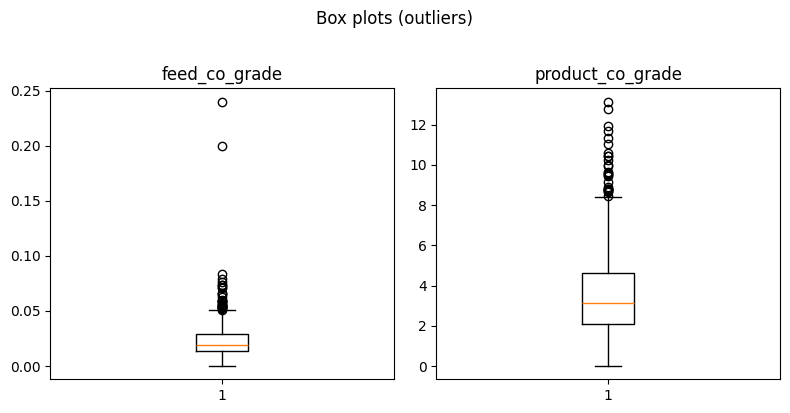

In [7]:
# EDA: box plots (outliers) and outlier counts (IQR method)
import matplotlib.pyplot as plt
import numpy as np

def count_outliers_iqr(series):
    q1, q3 = series.quantile(0.25), series.quantile(0.75)
    iqr = q3 - q1
    low, high = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return (series < low).sum(), (series > high).sum(), low, high

print('Outlier counts (IQR: below Q1-1.5*IQR or above Q3+1.5*IQR):')
for col in data.columns:
    n_lo, n_hi, lo, hi = count_outliers_iqr(data[col])
    print('  {}: {} below {:.4f}, {} above {:.4f} (total outliers: {})'.format(col, n_lo, lo, n_hi, hi, n_lo + n_hi))

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for i, col in enumerate(data.columns):
    axes[i].boxplot(data[col].dropna(), vert=True)
    axes[i].set_title(col)
    axes[i].set_ylabel('')
plt.suptitle('Box plots (outliers)', y=1.02)
plt.tight_layout()
plt.show()

Correlation matrix:
                  feed_co_grade  product_co_grade
feed_co_grade            1.0000            0.4652
product_co_grade         0.4652            1.0000


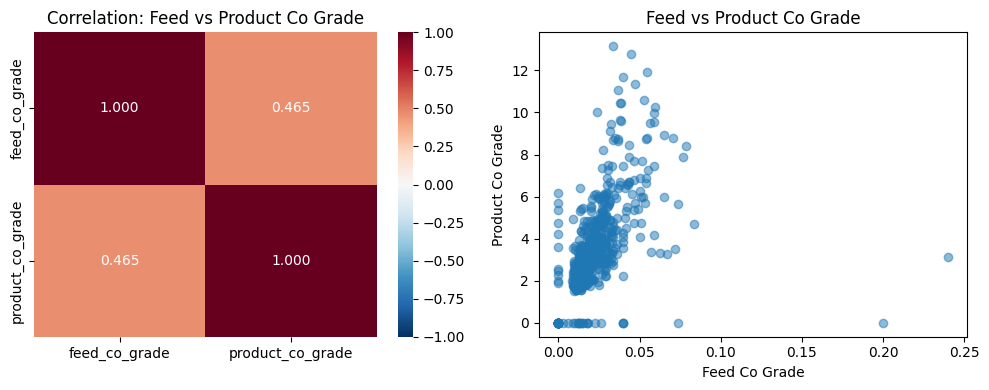

In [8]:
# EDA: correlation matrix and scatter (feature vs target)
import seaborn as sns

corr = data.corr()
print('Correlation matrix:')
print(corr.round(4))
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(corr, annot=True, fmt='.3f', cmap='RdBu_r', center=0, ax=axes[0], vmin=-1, vmax=1)
axes[0].set_title('Correlation: Feed vs Product Co Grade')
axes[1].scatter(data['feed_co_grade'], data['product_co_grade'], alpha=0.5)
axes[1].set_xlabel('Feed Co Grade')
axes[1].set_ylabel('Product Co Grade')
axes[1].set_title('Feed vs Product Co Grade')
plt.tight_layout()
plt.show()

### Statistical significance (statsmodels OLS)

Fit OLS (Ordinary Least Squares) with a constant to get **coefficients, standard errors, t-statistics, and p-values** for the relationship Product Co Grade ~ Feed Co Grade. Low p-value (&lt; 0.05) for the slope suggests the feature is statistically significant.

### Filter by runtime (optional)

Keep only shifts with **runtime > 60%** (e.g. runtime column in 0–1 scale: keep rows where `runtime > 0.6`). Print how many rows are lost; then build feature/target and retrain on the filtered dataset.

In [9]:
# Find Runtime column (MultiIndex or flat)
runtime_col = None
for c in df.columns:
    if 'Runtime' in str(c) or 'runtime' in str(c).lower():
        runtime_col = c
        break
if runtime_col is None:
    print('Runtime column not found. Skipping filter; using full df.')
else:
    # Use 0.6 if runtime is 0-1; use 60 if column is 0-100 (percentage)
    RUNTIME_MIN = 0.6
    n_before = len(df)
    # Handle possible string or mixed types
    runtime_vals = pd.to_numeric(df[runtime_col], errors='coerce')
    mask = runtime_vals > RUNTIME_MIN
    df = df.loc[mask].copy()
    n_after = len(df)
    n_lost = n_before - n_after
    print('Filter: runtime > {} (60%)'.format(RUNTIME_MIN))
    print('Rows before filter:', n_before)
    print('Rows after filter:', n_after)
    print('Rows lost:', n_lost, '({:.1f}%)'.format(100 * n_lost / n_before if n_before else 0))

Filter: runtime > 0.6 (60%)
Rows before filter: 557
Rows after filter: 320
Rows lost: 237 (42.5%)


## 4. Build feature (X) and target (y)

Build the modeling dataframe: keep only **Feed Co Grade** and **Product Co Grade**, drop rows with missing values, then create **X** (feature) and **y** (target). Optional: run the runtime filter above first to restrict to high-runtime rows.

In [10]:
# Build feature (X) and target (y); drop rows with missing Co grades
data = df[[col_feed_co, col_product_co]].copy()
data = data.dropna()
data.columns = ['feed_co_grade', 'product_co_grade']
X = data[['feed_co_grade']].values
y = data['product_co_grade'].values
print('Samples after dropna:', len(data))
print('Feed Co Grade: min={:.4f}, max={:.4f}, mean={:.4f}'.format(X.min(), X.max(), X.mean()))
print('Product Co Grade: min={:.4f}, max={:.4f}, mean={:.4f}'.format(y.min(), y.max(), y.mean()))

Samples after dropna: 320
Feed Co Grade: min=0.0092, max=0.0786, mean=0.0253
Product Co Grade: min=0.0000, max=13.1489, mean=4.2099


## 5. Train/test split and linear regression

Split data 80/20, fit `LinearRegression` (Product Co Grade ~ Feed Co Grade), then print intercept, coefficient, R² and a scatter of actual vs predicted.

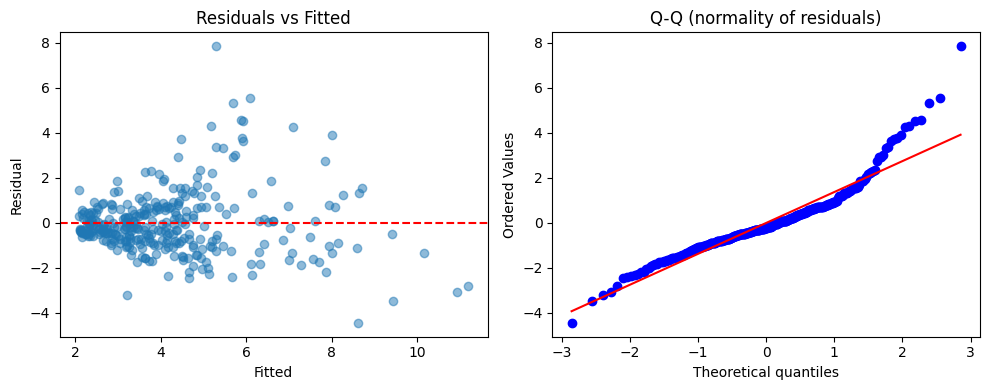

In [11]:
import statsmodels.api as sm
from scipy import stats as scipy_stats

# Fit OLS here so this cell works even if the statsmodels cell above was skipped
X_ols = sm.add_constant(data['feed_co_grade'])
y_ols = data['product_co_grade']
ols = sm.OLS(y_ols, X_ols).fit()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
fitted = ols.fittedvalues
resid = ols.resid
axes[0].scatter(fitted, resid, alpha=0.5)
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_xlabel('Fitted')
axes[0].set_ylabel('Residual')
axes[0].set_title('Residuals vs Fitted')
scipy_stats.probplot(resid, dist='norm', plot=axes[1])
axes[1].set_title('Q-Q (normality of residuals)')
plt.tight_layout()
plt.show()

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Linear regression: Product Co Grade ~ Feed Co Grade')
print('Intercept: {:.4f}'.format(model.intercept_))
print('Coefficient (Feed Co Grade): {:.4f}'.format(model.coef_[0]))
print('R² (test): {:.4f}'.format(r2_score(y_test, y_pred)))
print('MAE (test): {:.4f}'.format(mean_absolute_error(y_test, y_pred)))

Linear regression: Product Co Grade ~ Feed Co Grade
Intercept: 0.8067
Coefficient (Feed Co Grade): 136.3704
R² (test): 0.4990
MAE (test): 0.9832


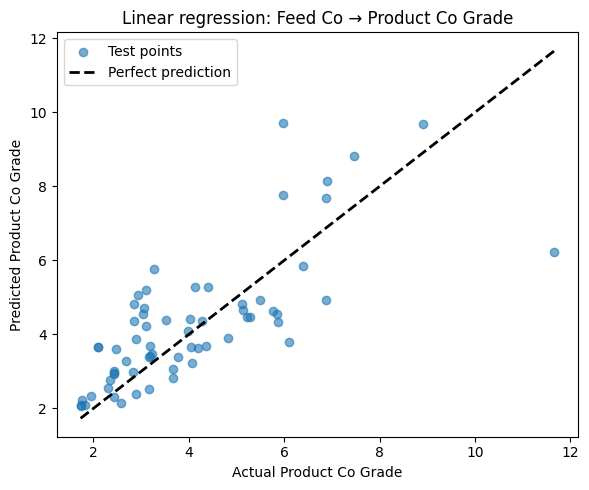

In [13]:
# Actual vs predicted (test set)
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred, alpha=0.6, label='Test points')
mn = min(y_test.min(), y_pred.min())
mx = max(y_test.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx], 'k--', lw=2, label='Perfect prediction')
plt.xlabel('Actual Product Co Grade')
plt.ylabel('Predicted Product Co Grade')
plt.title('Linear regression: Feed Co → Product Co Grade')
plt.legend()
plt.tight_layout()
plt.show()

## 6. Improving model metrics (outliers)

**Suggestions (given your outlier counts):**
1. **Winsorize** feed and product Co grade at 1st/99th percentile (on train only, then apply same bounds to test) so extreme values don’t dominate the fit.
2. **Log-transform** the target (Product Co Grade) if it’s right-skewed; fit on log scale and convert predictions back for evaluation.
3. **Robust regression** (e.g. statsmodels RLM with Huber weights) to down-weight outliers instead of clipping.

Compare **baseline** (raw fit), **winsorized** (clip at 1st/99th on train), and **remove outliers** (drop rows outside 1st/99th). Each model is reported with **R²**, **Adj R²**, **t-value** (slope), and **95% confidence interval** for the slope (from OLS).

In [14]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

# Same split as in Section 5 (for fair comparison)
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

def mape_safe(act, pred):
    act, pred = np.asarray(act), np.asarray(pred)
    mask = act != 0
    return np.mean(np.abs((act[mask] - pred[mask]) / act[mask])) * 100 if np.any(mask) else np.nan

def ols_stats(X, y):
    """Return adj R², t-value (slope), and 95% CI for slope from OLS."""
    X_const = sm.add_constant(np.asarray(X).reshape(-1, 1) if X.ndim == 1 else X)
    ols = sm.OLS(y, X_const).fit()
    adj_r2 = ols.rsquared_adj
    t_slope = ols.tvalues.iloc[1] if hasattr(ols.tvalues, 'iloc') else ols.tvalues[1]
    ci = ols.conf_int().iloc[1] if hasattr(ols.conf_int(), 'iloc') else ols.conf_int()[1]
    return adj_r2, t_slope, ci[0], ci[1]

# --- Baseline ---
m_baseline = LinearRegression().fit(X_train, y_train)
pred_baseline = m_baseline.predict(X_test)
r2_base = r2_score(y_test, pred_baseline)
mae_base = mean_absolute_error(y_test, pred_baseline)
adj_r2_base, t_base, ci_lo_base, ci_hi_base = ols_stats(X_train, y_train)

# --- Winsorized: 1st/99th on TRAIN only, then clip train and test ---
p1_x = np.nanpercentile(X_train, 1)
p99_x = np.nanpercentile(X_train, 99)
p1_y = np.nanpercentile(y_train, 1)
p99_y = np.nanpercentile(y_train, 99)
X_train_w = np.clip(X_train, p1_x, p99_x)
X_test_w = np.clip(X_test, p1_x, p99_x)
y_train_w = np.clip(y_train, p1_y, p99_y)
m_winsor = LinearRegression().fit(X_train_w, y_train_w)
pred_winsor = m_winsor.predict(X_test_w)
r2_w = r2_score(y_test, pred_winsor)
mae_w = mean_absolute_error(y_test, pred_winsor)
adj_r2_w, t_w, ci_lo_w, ci_hi_w = ols_stats(X_train_w, y_train_w)

# --- Remove outliers: drop rows outside 1st/99th (bounds from train) ---
p1_x, p99_x = np.nanpercentile(X_train, 1), np.nanpercentile(X_train, 99)
p1_y, p99_y = np.nanpercentile(y_train, 1), np.nanpercentile(y_train, 99)
in_range_train = ((X_train >= p1_x) & (X_train <= p99_x)).flatten() & (y_train >= p1_y) & (y_train <= p99_y)
in_range_test = ((X_test >= p1_x) & (X_test <= p99_x)).flatten() & (y_test >= p1_y) & (y_test <= p99_y)
X_tr, y_tr = X_train[in_range_train], y_train[in_range_train]
X_te, y_te = X_test[in_range_test], y_test[in_range_test]
m_remove = LinearRegression().fit(X_tr, y_tr)
pred_remove = m_remove.predict(X_te)
r2_remove = r2_score(y_te, pred_remove)
mae_remove = mean_absolute_error(y_te, pred_remove)
n_train_kept, n_test_kept = in_range_train.sum(), in_range_test.sum()
n_train_removed = len(X_train) - n_train_kept
n_test_removed = len(X_test) - n_test_kept
n_outliers_removed_total = n_train_removed + n_test_removed
adj_r2_remove, t_remove, ci_lo_remove, ci_hi_remove = ols_stats(X_tr, y_tr)

mape_base = mape_safe(y_test, pred_baseline)
mape_w = mape_safe(y_test, pred_winsor)
mape_remove = mape_safe(y_te, pred_remove)

# Comparison: baseline, clip, remove outliers (Adj R², t-value, 95% CI for slope)
comparison = pd.DataFrame({
    'Model': ['Baseline (raw)', 'Winsorized (clip 1st/99th)', 'Remove outliers'],
    'R² (test)': [r2_base, r2_w, r2_remove],
    'Adj R²': [adj_r2_base, adj_r2_w, adj_r2_remove],
    'MAE (test)': [mae_base, mae_w, mae_remove],
    'MAPE (%)': [mape_base, mape_w, mape_remove],
    't (slope)': [t_base, t_w, t_remove],
    'CI 95% (slope)': ['[{:.4f}, {:.4f}]'.format(ci_lo_base, ci_hi_base), '[{:.4f}, {:.4f}]'.format(ci_lo_w, ci_hi_w), '[{:.4f}, {:.4f}]'.format(ci_lo_remove, ci_hi_remove)]
})
print('Comparison: baseline, winsorized (clip), remove outliers. CI = 95% confidence interval for slope.')
print(comparison.to_string(index=False))
print('\nOutliers removed (1st/99th): {} from train, {} from test ({} total). Rows kept: train={}, test={}.'.format(n_train_removed, n_test_removed, n_outliers_removed_total, n_train_kept, n_test_kept))

Comparison: baseline, winsorized (clip), remove outliers. CI = 95% confidence interval for slope.
                     Model  R² (test)   Adj R²  MAE (test)  MAPE (%)  t (slope)       CI 95% (slope)
            Baseline (raw)   0.499026 0.588066    0.983213 25.546228  19.105795 [122.3139, 150.4269]
Winsorized (clip 1st/99th)   0.485760 0.617792    0.994348 25.568499  20.326738 [127.9893, 155.4503]
           Remove outliers   0.470126 0.600058    0.878199 24.641402  19.120357 [126.1096, 155.0780]

Outliers removed (1st/99th): 12 from train, 4 from test (16 total). Rows kept: train=244, test=60.


## 7. Ridge (hyperparameter tuning) and other models

- **Ridge:** Tune regularization strength `alpha` via cross-validation on the training set; report best alpha and test R²/MAE.
- **Random Forest, XGBoost, Gradient Boosting:** Fit with sensible defaults (and optional quick tune); compare test R² and MAE to linear/Ridge.
- Same train/test split and data (no log, no removal) for fair comparison.

In [15]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import statsmodels.api as sm

def mape_safe(act, pred):
    act, pred = np.asarray(act), np.asarray(pred)
    mask = act != 0
    return np.mean(np.abs((act[mask] - pred[mask]) / act[mask])) * 100 if np.any(mask) else np.nan

RANDOM_STATE = 42
# Ensure we have the same split (X_train, X_test, y_train, y_test from previous cells)
# If not run yet: X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# --- Ridge: hyperparameter tuning (alpha) with 5-fold CV on train ---
ridge_cv = GridSearchCV(Ridge(random_state=RANDOM_STATE), param_grid={'alpha': [0.01, 0.1, 1, 10, 100, 1000]}, cv=5, scoring='neg_mean_absolute_error')
ridge_cv.fit(X_train, y_train)
best_alpha = ridge_cv.best_params_['alpha']
ridge_best = Ridge(alpha=best_alpha, random_state=RANDOM_STATE).fit(X_train, y_train)
pred_ridge = ridge_best.predict(X_test)
r2_ridge = r2_score(y_test, pred_ridge)
mae_ridge = mean_absolute_error(y_test, pred_ridge)
print('Ridge: best alpha = {}, R² (test) = {:.4f}, MAE (test) = {:.4f}'.format(best_alpha, r2_ridge, mae_ridge))

# --- Random Forest ---
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=RANDOM_STATE).fit(X_train, y_train)
pred_rf = rf.predict(X_test)
r2_rf = r2_score(y_test, pred_rf)
mae_rf = mean_absolute_error(y_test, pred_rf)

# --- XGBoost ---
xgb = XGBRegressor(n_estimators=100, max_depth=5, random_state=RANDOM_STATE).fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)
r2_xgb = r2_score(y_test, pred_xgb)
mae_xgb = mean_absolute_error(y_test, pred_xgb)

# --- Gradient Boosting ---
gb = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=RANDOM_STATE).fit(X_train, y_train)
pred_gb = gb.predict(X_test)
r2_gb = r2_score(y_test, pred_gb)
mae_gb = mean_absolute_error(y_test, pred_gb)

# --- Extra Trees (often robust alternative to RF) ---
et = ExtraTreesRegressor(n_estimators=100, max_depth=10, random_state=RANDOM_STATE).fit(X_train, y_train)
pred_et = et.predict(X_test)
r2_et = r2_score(y_test, pred_et)
mae_et = mean_absolute_error(y_test, pred_et)

# Baseline predictions and metrics (for MAPE and table; same as Section 4 if run)
pred_baseline = LinearRegression().fit(X_train, y_train).predict(X_test)
r2_base = r2_score(y_test, pred_baseline)
mae_base = mean_absolute_error(y_test, pred_baseline)

# MAPE for all models
mape_base = mape_safe(y_test, pred_baseline)
mape_ridge = mape_safe(y_test, pred_ridge)
mape_rf = mape_safe(y_test, pred_rf)
mape_xgb = mape_safe(y_test, pred_xgb)
mape_gb = mape_safe(y_test, pred_gb)
mape_et = mape_safe(y_test, pred_et)

# --- Comparison table (include baseline linear from Section 3/4) ---
models_comparison = pd.DataFrame({
    'Model': ['Linear (baseline)', 'Ridge (tuned)', 'Random Forest', 'XGBoost', 'Gradient Boosting', 'Extra Trees'],
    'R² (test)': [r2_base, r2_ridge, r2_rf, r2_xgb, r2_gb, r2_et],
    'MAE (test)': [mae_base, mae_ridge, mae_rf, mae_xgb, mae_gb, mae_et],
    'MAPE (%)': [mape_base, mape_ridge, mape_rf, mape_xgb, mape_gb, mape_et]
})
print('\nAll models (same train/test split):')
print(models_comparison.to_string(index=False))

# --- OLS summary (statsmodels) for p-values ---
X_ols = sm.add_constant(X_train)
ols = sm.OLS(y_train, X_ols).fit()
print('\nOLS summary (coefficients and p-values, fit on training data):')
print(ols.summary2().tables[1].to_string())
print('\nFull OLS summary:')
print(ols.summary())

Ridge: best alpha = 0.01, R² (test) = 0.5336, MAE (test) = 0.9519

All models (same train/test split):
            Model  R² (test)  MAE (test)  MAPE (%)
Linear (baseline)   0.499026    0.983213 25.546228
    Ridge (tuned)   0.533593    0.951907 26.587003
    Random Forest   0.317835    1.101604 27.527391
          XGBoost   0.185102    1.222555 31.145715
Gradient Boosting   0.271420    1.134329 27.513807
      Extra Trees   0.273431    1.126812 28.288588

OLS summary (coefficients and p-values, fit on training data):
            Coef.  Std.Err.          t         P>|t|      [0.025      0.975]
const    0.806713  0.202422   3.985310  8.811182e-05    0.408074    1.205352
x1     136.370351  7.137643  19.105795  4.775142e-51  122.313850  150.426851

Full OLS summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:             